In [4]:
conda install -c conda-forge lightgbm

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/miyatayouhei/opt/anaconda3/envs/myenv

  added / updated specs:
    - lightgbm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.12.5  |       h033912b_0         138 KB  conda-forge
    certifi-2020.12.5          |   py37hf985489_1         143 KB  conda-forge
    lightgbm-3.1.1             |   py37h23ab428_0         862 KB
    openssl-1.1.1i             |       h35c211d_0         1.9 MB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The foll

In [32]:
#imports 
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
import sklearn.datasets
from sklearn.metrics import accuracy_score,log_loss,roc_auc_score
from sklearn.model_selection import train_test_split
# import optuna 
import lightgbm as lgb
# import xgboost as xgb

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Others
from tqdm import tqdm
# import shap
pd.set_option('display.max_columns', 1000)
%matplotlib inline
from matplotlib_venn import venn2
from matplotlib import pyplot


In [12]:
log_df = pd.read_csv("../input/carlog.csv", dtype={ 'value_1': str }, parse_dates=['date'])

In [3]:
log_df.shape

(14632775, 18)

In [20]:
log_df.tail(50).T

,14632725,14632726,14632727,14632728,14632729,14632730,14632731,14632732,14632733,14632734,14632735,14632736,14632737,14632738,14632739,14632740,14632741,14632742,14632743,14632744,14632745,14632746,14632747,14632748,14632749,14632750,14632751,14632752,14632753,14632754,14632755,14632756,14632757,14632758,14632759,14632760,14632761,14632762,14632763,14632764,14632765,14632766,14632767,14632768,14632769,14632770,14632771,14632772,14632773,14632774
session_id,795898,795898,795898,795898,795902,795909,795912,795912,795912,795912,795912,795918,795918,795918,795918,795918,795918,795918,795918,795918,795918,795918,795918,795918,795919,795919,795919,795922,795922,795922,795922,795922,795922,795922,795922,795922,795922,795922,795924,795927,795927,795927,795927,795932,795932,795932,795932,795933,795933,795933
register_number,1098,1098,1098,1098,1208,1007,1011,1011,1011,1011,1011,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1069,1069,1069,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1208,1217,1217,1217,1217,1021,1021,1021,1021,1069,1069,1069
date,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00
hour,21,21,21,21,21,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,23,23,23,23,23,23,23
spend_time,116,287,298,527,0,0,0,78,96,129,218,0,84,85,87,89,146,243,245,247,250,253,256,298,0,81,108,0,82,131,138,162,190,337,434,470,512,536,0,0,83,129,174,0,41,131,147,0,104,112
display_action_id,209,209,209,209,141,141,141,209,209,209,209,137,209,209,209,209,209,209,209,209,209,209,209,209,141,209,209,141,209,117,209,209,209,209,209,209,209,209,137,137,209,209,209,141,209,209,209,137,209,209
user_id,6J8aKBVabfojKFuau4nCHo,6J8aKBVabfojKFuau4nCHo,6J8aKBVabfojKFuau4nCHo,6J8aKBVabfojKFuau4nCHo,NaN,NaN,NaN,9YL7xeLQjiSiPBStfUoH26,9YL7xeLQjiSiPBStfUoH26,9YL7xeLQjiSiPBStfUoH26,9YL7xeLQjiSiPBStfUoH26,NaN,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,TobEvQCPAryz6LZv4o5U8M,NaN,knyVunEs2MF6ZfgpvNBvy2,knyVunEs2MF6ZfgpvNBvy2,NaN,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,bA8AXYgJf2eK9H694wvzdv,NaN,NaN,HCgdYHT8pVt9v3Y2jyoCs5,HCgdYHT8pVt9v3Y2jyoCs5,HCgdYHT8pVt9v3Y2jyoCs5,NaN,fipZ5RY7m4XXSoWxpDzDht,fipZ5RY7m4XXSoWxpDzDht,fipZ5RY7m4XXSoWxpDzDht,NaN,U88W98UzTEgNx55qGMS4iq,U88W98UzTEgNx55qGMS4iq
value_1,2539735000000,2523571000000,2514669000000,4950349611756,NaN,NaN,NaN,2539604000000,2539604000000,4983466040338,4976880925961,2960031444960,4902930040001,4902930040001,4902930040001,4902930040001,2501064000000,4560243580128,4560243580128,4560243580128,4560243580128,4560243580128,4560243580128,4902777090412,NaN,4528594000009,4990067829712,NaN,2537956000000,2537956000000,2541004000000,499

In [13]:
meta_df = pd.read_csv("../input/meta.csv", parse_dates=['date'])

In [6]:
meta_df.shape

(795936, 6)

In [7]:
meta_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed
0,0,bE94Gct4vGiKM7z2Y79cjk,2019-02-14,4,2003,NaN
1,1,V4bEuaKPEPoK8MswqPksvK,2019-02-14,4,2006,NaN
2,2,ntRurFKVWYBQR86auef5Fc,2019-02-14,5,2001,NaN
3,3,GhHaHMCyrz76y2dCeVXfbn,2019-02-14,5,2001,NaN
4,4,kG58HejrEcbjJQ7JojRSay,2019-02-14,5,2002,NaN


In [14]:
product_df = pd.read_csv("../input/product_master.csv", dtype={ 'JAN': str }) # lod_dfのデータ型と合わせる
user_df = pd.read_csv("../input/user_master.csv")

In [10]:
product_df.shape , user_df.shape

((1965937, 14), (40350, 3))

In [12]:
product_df.tail().T

,1965932,1965933,1965934,1965935,1965936
JAN,9999999999482,9999999999499,9999999999963,9999999999994,9999999999999
商品名,ベーカリー,テスト用,0,テスト用,**
部門CD,125,49,96,26,99
部門名,バラパン,米飯(麺),たばこ,雑誌･CD,サービス
カテゴリCD,1,7,99,99,10
カテゴリ名,菓子パン,原料・包材（米飯）,たばこその他,雑誌その他,売上扱い
サブカテゴリCD,8,1,99,99,99
サブカテゴリ名,菓子パンその他,原料（米飯）,たばこその他,雑誌その他,サービスその他
セグメントCD,1,1,99,99,99
セグメント名,菓子パンその他,原料（米飯）,たばこその他,雑誌その他,その他


In [26]:
user_df.head()

,user_id,age,gender
0,NaN,NaN,NaN
1,222BJXjf8z6YfvHVLvjbhK,40.0,0.0
2,2285uFEmqQNtttDNKPc7Zh,30.0,1.0
3,22CVr2MdbLSkbXycnChGQd,30.0,0.0
4,22KGbCvUqtWPXFsdeCWnrQ,70.0,9.0


In [14]:
product_df.query('JAN=="4522646719765"')

,JAN,商品名,部門CD,部門名,カテゴリCD,カテゴリ名,サブカテゴリCD,サブカテゴリ名,セグメントCD,セグメント名,サブセグメントCD,サブセグメント名,category_name,category_id
477248,4522646719765,おかかおにぎり,49,米飯(麺),1,おにぎり,1,三角おにぎり,2,おかか,98,設定なし,米飯(麺)__おにぎり,617


In [15]:
product_df.query('JAN=="4522646695663"')

,JAN,商品名,部門CD,部門名,カテゴリCD,カテゴリ名,サブカテゴリCD,サブカテゴリ名,セグメントCD,セグメント名,サブセグメントCD,サブセグメント名,category_name,category_id
474973,4522646695663,梅（種なし）おにぎり,49,米飯(麺),1,おにぎり,1,三角おにぎり,3,梅,98,設定なし,米飯(麺)__おにぎり,617


## testデータの確認

In [58]:
test_df = pd.read_csv("../input/test.csv")

In [22]:
test_df.shape

(56486, 1)

## First Submit！
- JANコードから予測ジャンル値に変換する
- まずは、購入有無に関わらず、１セッション内での予測ジャンルの有無（Not個数、まずは）をgroupbyで出して特徴量化
- 年齢や性別などの、すぐに付与できる特徴量をつける
- trainとtestに分ける（特徴量つくってから）
- 予測対象カテゴリを除外して、モデリング　×　１５カテゴリ分
- 各カテゴリごとに予測を出して、横concatし、submitする


In [23]:
product_df["category_id"].value_counts()

517    113390
0       76413
246     71363
213     36786
262     35175
        ...  
190         1
626         1
107         1
749         1
742         1
Name: category_id, Length: 772, dtype: int64

In [16]:
df = pd.merge(log_df, product_df[["JAN", "category_id"]], left_on="value_1", right_on="JAN", how="left")

In [33]:
df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
session_id,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,5
register_number,2003,2003,2003,2003,2003,2003,2003,2003,2003,2003,2006,2006,2006,2006,2006,2006,2006,2006,2006,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2001,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002
date,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00,2019-02-14 00:00:00
hour,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
spend_time,0,32,37,52,59,72,81,86,133,140,0,42,61,72,81,91,93,99,101,0,9,14,21,27,32,34,37,39,0,118,136,161,167,179,187,206,211,213,220,0,33,35,41,44,0,38,45,48,49,58
display_action_id,136,209,209,209,209,209,218,73,59,105,141,209,209,209,209,209,218,73,105,141,209,209,209,209,209,218,73,105,136,209,209,209,209,209,209,209,218,77,105,141,209,218,73,105,136,209,209,218,77,105
user_id,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,bE94Gct4vGiKM7z2Y79cjk,NaN,V4bEuaKPEPoK8MswqPksvK,V4bEuaKPEPoK8MswqPksvK,V4bEuaKPEPoK8MswqPksvK,V4bEuaKPEPoK8MswqPksvK,V4bEuaKPEPoK8MswqPksvK,V4bEuaKPEPoK8MswqPksvK,V4bEuaKPEPoK8MswqPksvK,V4bEuaKPEPoK8MswqPksvK,NaN,ntRurFKVWYBQR86auef5Fc,ntRurFKVWYBQR86auef5Fc,ntRurFKVWYBQR86auef5Fc,ntRurFKVWYBQR86auef5Fc,ntRurFKVWYBQR86auef5Fc,ntRurFKVWYBQR86auef5Fc,ntRurFKVWYBQR86auef5Fc,ntRurFKVWYBQR86auef5Fc,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,GhHaHMCyrz76y2dCeVXfbn,NaN,kG58HejrEcbjJQ7JojRSay,kG58HejrEcbjJQ7JojRSay,kG58HejrEcbjJQ7JojRSay,kG58HejrEcbjJQ7JojRSay,aevjzCB5vr8sjgM3yfq82C,aevjzCB5vr8sjgM3yfq82C,aevjzCB5vr8sjgM3yfq82C,aevjzCB5vr8sjgM3yfq82C,aevjzCB5vr8sjgM3yfq82C,aevjzCB5vr8sjgM3yfq82C
value_1,NaN,4522646719765,4522646695663,4522646716641,4522646695670,4522646720440,NaN,4522646330991,NaN,NaN,NaN,4522646754407,4528594000009,4902720069021,2528985000000,2572988000000,NaN,4522646330991,NaN,NaN,4901140907050,4901140907050,4908011706750,4522646695663,4522646695670,NaN,4522646330991,NaN,NaN,4974679010225,4943279001056,4901468260721,4901366015003,4902410315353,4970470054000,4901777300057,NaN,1,NaN,NaN,4902505341038,NaN,4522646330991,NaN,NaN,4522646331332,4902410140962,NaN,1,NaN
name_1,NaN,おかかおにぎり ５９円,梅（種なし）おにぎり５９,紅鮭おにぎり７９円,明太子おにぎり ７９円,ツナマヨおにぎり,NaN,レジ袋,NaN,NaN,NaN,紳士クッショニングサンダ,バナナＣＰ２４,ピクニック_ココア,匠のサラダ巻き寿司（４巻,いなり３個,NaN,レジ袋,NaN,NaN,サンボンベ,サンボンベ,野菜Ｄａｙｓ_野菜＆フルー,梅（種なし）おにぎり５９,明太子おにぎり ７９円,NaN,レジ袋,NaN,NaN,根切りもやし,カットネギ,札幌ラーメン味噌,麺好亭 焼豚,ピザパン,クリーム大福（いちご・プ,なっちゃんしゅわしゅわ白,NaN,NaN,NaN,NaN,オプトボール_カーボン,NaN,レジ袋,NaN,NaN,酪農牛乳,トライアルブレッド（６）,NaN,NaN,NaN
kind_1,NaN,商品,商品,商品,商品,商品,NaN,商品,NaN,NaN,NaN,

In [35]:
df.category_id.nunique()

681

In [64]:
df["session_id"].nunique()

720175

In [17]:
tmp = df.groupby(['session_id', 'category_id']).size().reset_index().astype({"category_id":int})

In [9]:
tmp

,session_id,category_id,0
0,0,240,1
1,0,617,5
2,1,99,1
3,1,240,1
4,1,451,1
...,...,...,...
7197932,795927,768,1
7197933,795932,526,1
7197934,795932,771,2
7197935,795933,134,1


In [65]:
tmp["session_id"].nunique()

678810

In [69]:
list(set(df["session_id"].unique())-set(tmp["session_id"].unique()))[:5]

[786432, 262145, 131074, 262146, 786433]

In [76]:
len(list(set(df["session_id"].unique())-set(tmp["session_id"].unique())))

41365

In [77]:
df.query('session_id == 786432 or session_id == 262145 or session_id == 131074 or session_id == 262146 or session_id == 786433').T

,2664992,5264825,5264826,14604019,14604020
session_id,131074,262145,262146,786432,786433
register_number,1143,1100,1100,1205,1208
date,2019-05-17 00:00:00,2019-08-15 00:00:00,2019-08-15 00:00:00,2020-11-22 00:00:00,2020-11-22 00:00:00
hour,13,15,15,11,11
spend_time,0,0,0,0,0
display_action_id,141,141,141,141,137
user_id,JfCwjbSQpJ5KvceSfCJAyU,575r8jerJ8is2vrLxs4Bn5,575r8jerJ8is2vrLxs4Bn5,NaN,NaN
value_1,NaN,NaN,NaN,NaN,2960015267257
name_1,NaN,NaN,NaN,NaN,スキャンデータ
kind_1,NaN,NaN,NaN,NaN,バーコードスキャン


In [74]:
df.query('session_id == 131075').T

,2664993,2664994,2664995,2664996,2664997,2664998,2664999,2665000,2665001,2665002,2665003,2665004,2665005,2665006,2665007,2665008,2665009,2665010,2665011,2665012,2665013
session_id,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075,131075
register_number,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144,1144
date,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00,2019-05-17 00:00:00
hour,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
spend_time,0,21,29,36,40,48,56,60,67,74,81,87,90,92,99,103,105,117,118,121,151
display_action_id,136,209,209,209,209,209,209,209,209,209,209,209,187,209,209,187,209,218,77,73,105
user_id,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ,FVdNdqekTzA6dbqCvtgfZJ
value_1,NaN,4902102129299,4902102129978,2528713000000,2528713000000,4990067829712,4966953300030,4902388026237,2532216000000,2532216000000,2532325000000,4903380189395,4529,4970470053447,4582216428077,4249,4903380450938,NaN,0,4522646330991,NaN
name_1,NaN,リアルスーパーリフレッシ,い･ろ･は･す日向夏&温州み,味付牛こま切れ（プルコギ,味付牛こま切れ（プルコギ,エノキ,マツモト食品 緑豆もやし,冷え知らずさんの生姜みそ,胡瓜１本,胡瓜１本,グリーンリーフ１玉,味ロール,味ロール,ももブッセ,かく天,かく天,あまおう苺ケーキ,NaN,NaN,レジ袋,NaN
kind_1,NaN,商品,商品,商品,商品,商品,商品,商品,商品,商品,商品,商品,クーポン,商品,商品,クーポン,商品,NaN,キー,商品,NaN


【わかったこと】漏れたsession_id 41365分は、どうやらsessionだけ始まったが、何も稼働していないノイズの模様  
 - なので、このsession_idたちの予測は、すべて「０」とすればよい

In [47]:
tmp2 = tmp.rename(columns={0:"count"})
# tmp2["count"]=1

In [48]:
tmp3 = pd.pivot_table(tmp2, index='session_id', columns='category_id')

In [12]:
tmp3.shape

(678810, 681)

In [49]:
tmp4 = pd.merge(tmp3, meta_df, on="session_id", how="left")

In [14]:
tmp4.head()

,session_id,"(count, 0)","(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 7)","(count, 8)","(count, 9)","(count, 11)","(count, 12)","(count, 13)","(count, 14)","(count, 23)","(count, 24)","(count, 25)","(count, 26)","(count, 27)","(count, 28)","(count, 29)","(count, 30)","(count, 31)","(count, 32)","(count, 33)","(count, 35)","(count, 36)","(count, 37)","(count, 38)","(count, 39)","(count, 40)","(count, 41)","(count, 42)","(count, 43)","(count, 44)","(count, 45)","(count, 46)","(count, 47)","(count, 48)","(count, 49)","(count, 50)","(count, 51)","(count, 52)","(count, 53)","(count, 54)","(count, 55)","(count, 56)","(count, 57)","(count, 58)","(count, 59)","(count, 60)","(count, 61)","(count, 62)","(count, 63)","(count, 64)","(count, 65)","(count, 66)","(count, 67)","(count, 68)","(count, 69)","(count, 71)","(count, 72)","(count, 73)","(count, 74)","(count, 76)","(count, 77)","(count, 78)","(count, 79)","(count, 80)","(count, 81)","(count, 82)","(count, 83)","(count, 84)","(count, 85)","(count, 86)","(count, 87)","(count, 88)","(count, 89)","(count, 90)","(count, 92)","(count, 93)","(count, 94)","(count, 95)","(count, 96)","(count, 97)","(count, 98)","(count, 99)","(count, 106)","(count, 108)","(count, 109)","(count, 110)","(count, 111)","(count, 112)","(count, 113)","(count, 114)","(count, 115)","(count, 116)","(count, 118)","(count, 119)","(count, 120)","(count, 121)","(count, 122)","(count, 123)","(count, 124)","(count, 125)","(count, 126)","(count, 127)","(count, 128)","(count, 129)","(count, 130)","(count, 131)","(count, 132)","(count, 133)","(count, 134)","(count, 135)","(count, 136)","(count, 137)","(count, 141)","(count, 142)","(count, 143)","(count, 144)","(count, 145)","(count, 146)","(count, 147)","(count, 148)","(count, 149)","(count, 150)","(count, 155)","(count, 156)","(count, 157)","(count, 158)","(count, 159)","(count, 160)","(count, 161)","(count, 162)","(count, 163)","(count, 164)","(count, 165)","(count, 166)","(count, 167)","(count, 168)","(count, 169)","(count, 170)","(count, 171)","(count, 172)","(count, 173)","(count, 181)","(count, 182)","(count, 183)","(count, 184)","(count, 185)","(count, 186)","(count, 188)","(count, 189)","(count, 191)","(count, 192)","(count, 193)","(count, 194)","(count, 195)","(count, 196)","(count, 197)","(count, 198)","(count, 199)","(count, 200)","(count, 201)","(count, 202)","(count, 203)","(count, 204)","(count, 205)","(count, 206)","(count, 207)","(count, 208)","(count, 209)","(count, 210)","(count, 211)","(count, 212)","(count, 213)","(count, 214)","(count, 215)","(count, 216)","(count, 217)","(count, 218)","(count, 219)","(count, 220)","(count, 221)","(count, 222)","(count, 223)","(count, 224)","(count, 225)","(count, 226)","(count, 227)","(count, 228)","(count, 229)","(count, 230)","(count, 231)","(count, 232)","(count, 233)","(count, 234)","(count, 235)","(count, 236)","(count, 237)","(count, 238)","(count, 239)","(count, 240)","(count, 242)","(count, 243)","(count, 244)","(count, 245)","(count, 246)","(count, 247)","(count, 248)","(count, 250)","(count, 251)","(count, 252)","(count, 253)","(count, 254)","(count, 255)","(count, 256)","(count, 257)","(count, 258)","(count, 259)","(count, 260)","(count, 261)","(count, 262)","(count, 263)","(count, 265)","(count, 266)","(count, 267)","(count, 268)","(count, 269)","(count, 270)","(count, 271)","(count, 272)","(count, 273)","(count, 274)","(count, 275)","(count, 276)","(count, 278)","(count, 279)","(count, 280)","(count, 281)","(count, 283)","(count, 284)","(count, 285)","(count, 286)","(count, 287)","(count, 288)","(count, 289)","(count, 290)","(count, 291)","(count, 292)","(count, 294)","(count, 295)","(count, 296)","(count, 297)","(count, 298)","(count, 299)","(count, 300)","(count, 301)","(count, 302)","(count, 303)","(count, 304)","(count, 305)","(count, 306)","(count, 307)","(count, 308)","(count, 309)","(count, 310)","(count, 311)","(count, 312)","(count, 313)","(count, 314)","(count, 315)","(c

In [50]:
tmp5 = pd.merge(tmp4, user_df, on="user_id", how="left")

In [28]:
tmp5.head()

,session_id,"(count, 0)","(count, 1)","(count, 2)","(count, 3)","(count, 4)","(count, 5)","(count, 7)","(count, 8)","(count, 9)","(count, 11)","(count, 12)","(count, 13)","(count, 14)","(count, 23)","(count, 24)","(count, 25)","(count, 26)","(count, 27)","(count, 28)","(count, 29)","(count, 30)","(count, 31)","(count, 32)","(count, 33)","(count, 35)","(count, 36)","(count, 37)","(count, 38)","(count, 39)","(count, 40)","(count, 41)","(count, 42)","(count, 43)","(count, 44)","(count, 45)","(count, 46)","(count, 47)","(count, 48)","(count, 49)","(count, 50)","(count, 51)","(count, 52)","(count, 53)","(count, 54)","(count, 55)","(count, 56)","(count, 57)","(count, 58)","(count, 59)","(count, 60)","(count, 61)","(count, 62)","(count, 63)","(count, 64)","(count, 65)","(count, 66)","(count, 67)","(count, 68)","(count, 69)","(count, 71)","(count, 72)","(count, 73)","(count, 74)","(count, 76)","(count, 77)","(count, 78)","(count, 79)","(count, 80)","(count, 81)","(count, 82)","(count, 83)","(count, 84)","(count, 85)","(count, 86)","(count, 87)","(count, 88)","(count, 89)","(count, 90)","(count, 92)","(count, 93)","(count, 94)","(count, 95)","(count, 96)","(count, 97)","(count, 98)","(count, 99)","(count, 106)","(count, 108)","(count, 109)","(count, 110)","(count, 111)","(count, 112)","(count, 113)","(count, 114)","(count, 115)","(count, 116)","(count, 118)","(count, 119)","(count, 120)","(count, 121)","(count, 122)","(count, 123)","(count, 124)","(count, 125)","(count, 126)","(count, 127)","(count, 128)","(count, 129)","(count, 130)","(count, 131)","(count, 132)","(count, 133)","(count, 134)","(count, 135)","(count, 136)","(count, 137)","(count, 141)","(count, 142)","(count, 143)","(count, 144)","(count, 145)","(count, 146)","(count, 147)","(count, 148)","(count, 149)","(count, 150)","(count, 155)","(count, 156)","(count, 157)","(count, 158)","(count, 159)","(count, 160)","(count, 161)","(count, 162)","(count, 163)","(count, 164)","(count, 165)","(count, 166)","(count, 167)","(count, 168)","(count, 169)","(count, 170)","(count, 171)","(count, 172)","(count, 173)","(count, 181)","(count, 182)","(count, 183)","(count, 184)","(count, 185)","(count, 186)","(count, 188)","(count, 189)","(count, 191)","(count, 192)","(count, 193)","(count, 194)","(count, 195)","(count, 196)","(count, 197)","(count, 198)","(count, 199)","(count, 200)","(count, 201)","(count, 202)","(count, 203)","(count, 204)","(count, 205)","(count, 206)","(count, 207)","(count, 208)","(count, 209)","(count, 210)","(count, 211)","(count, 212)","(count, 213)","(count, 214)","(count, 215)","(count, 216)","(count, 217)","(count, 218)","(count, 219)","(count, 220)","(count, 221)","(count, 222)","(count, 223)","(count, 224)","(count, 225)","(count, 226)","(count, 227)","(count, 228)","(count, 229)","(count, 230)","(count, 231)","(count, 232)","(count, 233)","(count, 234)","(count, 235)","(count, 236)","(count, 237)","(count, 238)","(count, 239)","(count, 240)","(count, 242)","(count, 243)","(count, 244)","(count, 245)","(count, 246)","(count, 247)","(count, 248)","(count, 250)","(count, 251)","(count, 252)","(count, 253)","(count, 254)","(count, 255)","(count, 256)","(count, 257)","(count, 258)","(count, 259)","(count, 260)","(count, 261)","(count, 262)","(count, 263)","(count, 265)","(count, 266)","(count, 267)","(count, 268)","(count, 269)","(count, 270)","(count, 271)","(count, 272)","(count, 273)","(count, 274)","(count, 275)","(count, 276)","(count, 278)","(count, 279)","(count, 280)","(count, 281)","(count, 283)","(count, 284)","(count, 285)","(count, 286)","(count, 287)","(count, 288)","(count, 289)","(count, 290)","(count, 291)","(count, 292)","(count, 294)","(count, 295)","(count, 296)","(count, 297)","(count, 298)","(count, 299)","(count, 300)","(count, 301)","(count, 302)","(count, 303)","(count, 304)","(count, 305)","(count, 306)","(count, 307)","(count, 308)","(count, 309)","(count, 310)","(count, 311)","(count, 312)","(count, 313)","(count, 314)","(count, 315)","(c

In [53]:
tmp5.drop(["user_id","date"],axis=1,inplace=True) # "register_number"は含める

In [ ]:
tmp5.columns

In [54]:
tmp5.columns = ["session_id"]+ sorted(list(tmp["category_id"].unique())) + ["hour","register_number","time_elapsed","age","gender"]

In [55]:
tmp5.head()

,session_id,0,1,2,3,4,5,7,8,9,11,12,13,14,23,24,25,26,27,28,29,30,31,32,33,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,71,72,73,74,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,92,93,94,95,96,97,98,99,106,108,109,110,111,112,113,114,115,116,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,141,142,143,144,145,146,147,148,149,150,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,181,182,183,184,185,186,188,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,242,243,244,245,246,247,248,250,251,252,253,254,255,256,257,258,259,260,261,262,263,265,266,267,268,269,270,271,272,273,274,275,276,278,279,280,281,283,284,285,286,287,288,289,290,291,292,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,319,321,322,323,324,325,326,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,405,406,407,408,409,410,411,413,414,415,416,417,418,419,420,421,422,423,424,425,426,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,484,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,502,503,504,505,506,507,508,509,510,511,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,571,572,573,574,575,576,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,594,595,596,597,598,599,600,601,602,604,606,607,608,610,612,613,615,616,617,618,619,620,621,622,623,624,625,627,628,629,630,631,632,633,634,635,636,639,640,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,693,694,695,696,697,698,699,700,701,702,703,704,705,707,708,709,710,711,712,713,714,715,716,717,718,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,751,752,753,754,755,756,758,759,761,762,763,764,765,766,767,768,769,770,771,hour,register_number,time_elapsed,age,gender
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [57]:
tmp4.shape , tmp5.shape

((678810, 687), (678810, 687))

## train/testセットに分ける

In [59]:
test_list = list(test_df["session_id"])
train = tmp5.query('session_id not in @test_list')
test = tmp5.query('session_id in @test_list')

In [52]:
train.shape,test.shape,tmp5.shape

((639660, 686), (39150, 686), (678810, 686))

In [53]:
len(test_list)

56486

19セッションだけ、carlogの中もセッション情報がない（ので、モデル学習できない？）
- 予測対象にはレジカートログに存在しないセッションもあることに注意してください。
- これは time_elapsed 以前にログが存在せず cartlog.csv 上にはレコードがないセッションがあるためです。

【todo】この19セッションのsession_idをみて、time_elapsedが「0」か、確認する
 - この19セッションはログが無いので、たとえば予測確率の平均で埋めるなどの特別処理をするか？

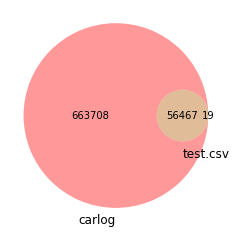

In [58]:
set1=set(log_df["session_id"].unique())
set2=set(test_df["session_id"])
venn2(subsets=[set1,set2] , set_labels=["carlog","test.csv"])

In [62]:
log_df["session_id"].nunique()

720175

tmp1→tmp5までの間に、消えたセッションがある・・・  
【todo】消えたセッションを確認し、復活させる  
 - 上記で確認済み、消えてるセッションは死んでいるセッションなので、予測は「０」にする

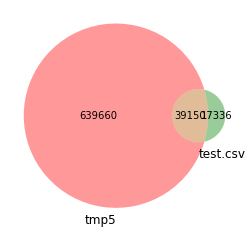

In [59]:
set1=set(tmp5["session_id"].unique())
set2=set(test_df["session_id"])
venn2(subsets=[set1,set2] , set_labels=["tmp5","test.csv"])

## define model

In [60]:
# "time_elapsed"はいったん考えずにbaselineつくる
train.drop("time_elapsed",axis=1,inplace=True)
test.drop("time_elapsed",axis=1,inplace=True)

In [61]:
predict_labels = [38,110,113,114,134,171,172,173,376,435,467,537,539,629,768]
len(predict_labels)

15

In [62]:
train.head().T

,0,1,2,3,4
session_id,0.0,1.0,2.0,3.0,4.0
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
771,NaN,NaN,NaN,NaN,NaN
hour,4.0,4.0,5.0,5.0,5.0
register_number,2003.0,2006.0,2001.0,2001.0,2002.0
age,40.0,30.0,50.0,30.0,30.0


### モデリング手順
test手順
- 予測対象のカラムを除外する

train手順
- 予測対象のカラムに値があればflgづけした目的変数カラムをつくる
- 予測対象のカラムを除外
- LightGBMでモデリングする（StratifidKfoldでやろう）
- できたモデルに対して、予測を行う
- 手元確認用に、validと正解ラベルにて、AUCも出しておく　※最後にmacroAUCにする
- 上記を、15ラベル分、繰り返す

In [63]:
tmp_df = train.copy()
tmp_df["target"] = 0
tmp_df.loc[~(tmp_df[1].isnull()), "target"] = 1
tmp_df.target.value_counts()

0    639448
1       212
Name: target, dtype: int64

In [64]:
# 石川さんパラメータに変更
params = {'num_leaves': 120,
         'metric': 'auc', # 要検討
         'objective': 'binary',
         'is_unbalance': True,  # これが効くか
         'max_depth': -1,
         'n_estimators': 500,
         'learning_rate': 0.05,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_fraction": 0.9 ,
         "lambda_l1": 0.1,
         "verbosity": -1,}

In [65]:
oof_collections = []
predict_collections = [] 

In [66]:
cnt=1

for predict_label in predict_labels:

    tmp_df = train.copy()
    tmp_df["target"] = 0
    tmp_df.loc[~(tmp_df[predict_label].isnull()), "target"] = 1

    tmp_df = tmp_df.drop([predict_label,"session_id"],axis=1)
    feature_df = tmp_df.drop("target",axis=1)
    target_df = tmp_df["target"] 

    test_df = test.drop([predict_label,"session_id"],axis=1)

    folds = StratifiedKFold(n_splits=2,random_state=42)
    # oof(out-of-fold)は、k-foldなどでデータ分割した際、学習に使わなかったデータのこと
    oof = np.zeros(len(feature_df))
    predictions = np.zeros(len(test_df))

    for fold , (trn_idx , val_idx) in enumerate(folds.split(feature_df,target_df)):
        print(f"{cnt}/15  predict label:{predict_label}  fold number:{fold}")
        t_df = lgb.Dataset(data=feature_df.iloc[trn_idx] , label=target_df[trn_idx])
        v_df = lgb.Dataset(data=feature_df.iloc[val_idx] , label=target_df[val_idx])
        
        clf = lgb.train(params , t_df , valid_sets=[t_df,v_df] ,verbose_eval=100, early_stopping_rounds=100)

        oof[val_idx] = clf.predict(feature_df.iloc[val_idx],num_iteration=clf.best_iteration)  

        predictions += clf.predict(test_df , num_iteration=clf.best_iteration) / folds.n_splits
    
    oof_collections.append(oof)
    predict_collections.append(predictions)

    cnt+=1

    # logloss 
    logloss =  log_loss(target_df,oof) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
    print('logloss :', logloss)

    # AUC 
    auc = roc_auc_score(target_df,oof) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
    print('AUC :', auc) 

    print("-"*20)

1/15  predict label:38  fold number:0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.834204	valid_1's auc: 0.745954
[200]	training's auc: 0.868262	valid_1's auc: 0.745438
Early stopping, best iteration is:
[119]	training's auc: 0.841998	valid_1's auc: 0.746125
1/15  predict label:38  fold number:1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.835726	valid_1's auc: 0.738298
Early stopping, best iteration is:
[61]	training's auc: 0.815787	valid_1's auc: 0.73898
logloss : 0.5139359054435695
AUC : 0.7386493119093891
--------------------
2/15  predict label:110  fold number:0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.931478	valid_1's auc: 0.701232
Early stopping, best iteration is:
[41]	training's auc: 0.883409	valid_1's auc: 0.710962
2/15  predict label:110  fold number:1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.930606	valid

In [67]:
pred_df = pd.DataFrame(predict_collections).T.reset_index(drop=True)
pred_df = pd.concat([test["session_id"].reset_index(drop=True), pred_df], axis=1)
pred_df.columns = ["session_id"] + predict_labels
pred_df

,session_id,38,110,113,114,134,171,172,173,376,435,467,537,539,629,768
0,663725,0.110930,0.443097,0.191367,0.181315,0.255543,0.412953,0.200205,0.635513,0.123958,0.272906,0.329407,0.845109,0.825177,0.459136,0.230758
1,663737,0.424195,0.453467,0.565944,0.727123,0.679797,0.555647,0.381643,0.543690,0.627881,0.479706,0.189250,0.503663,0.574375,0.680596,0.725591
2,663745,0.198623,0.256498,0.251533,0.161283,0.238305,0.202437,0.290382,0.369952,0.235758,0.312955,0.198638,0.337766,0.439082,0.281707,0.262533
3,663747,0.136547,0.241292,0.149790,0.141119,0.205100,0.160066,0.192647,0.279857,0.239611,0.276617,0.159340,0.283842,0.287430,0.213545,0.206333
4,663748,0.164627,0.227292,0.137407,0.137190,0.175659,0.175473,0.292021,0.358857,0.151771,0.311180,0.229585,0.274922,0.396111,0.289479,0.211284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39145,795919,0.500751,0.215626,0.335772,0.279749,0.279281,0.368018,0.282169,0.340384,0.219545,0.281683,0.278947,0.453257,0.327125,0.113195,0.260980
39146,795922,0.461672,0.130381,0.213725,0.363060,0.299401,0.492302,0.126052,0.256820,0.123242,0.444322,0.275353,0.243025,0.224984,0.073244,0.449948
39147,795927,0.487165,0.250957,0.224365,0.484441,0.463670,0.470456,0.221099,0.187618,0.151255,0.322009,0.385602,0.237773,0.202230,0.085464,0.338456
39148,795932,0.476959,0.184190,0.296577,0.430595,0.236095,0.388277,0.192766,0.338484,0.212370,0.382559,0.373443,0.349004,0.355638,0.206790,0.655378


In [68]:
test_id_df = pd.read_csv("../input/test.csv")
sub_df = pd.merge(test_id_df, pred_df, on="session_id", how="left")
sub_df = sub_df.fillna(sub_df.mean()) # sub_df.mean()で補完もできる

In [69]:
submit_df = sub_df.set_index("session_id")
submit_df.to_csv("../output/200201_01.csv",index=False)

AUC 0.5399 でした（CVつくろうね）